In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../MLearning/kaggle/airbnb/seattle'))
	print(os.getcwd())
except:
	pass


/home/elie/MLearning/kaggle/airbnb/seattle


# AIRBNB NOTEBOOK

## Libraries

In [129]:
#Get the Basics
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
import datetime
import pygments

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import folium as fo
import wordcloud as wo
import plotly as plo

#Scaling nicely
from sklearn.preprocessing import StandardScaler

#Models to be used
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

#Select relevant features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Select best model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [130]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Helper functions

In [131]:
def check_data(data):
    for column in data.columns.values:
        print("\n- {} :  \n\tunique values: {}\n\tnull values: {}".format(
              column,
              len(data[column].unique()),
              data[column].isnull().sum()))

def remove_dollar(data):
    data = data.apply(str)
    data = [float(x.strip('$').replace(',','')) for x in data]
    return data

def convert_boolstr(data):
    return data.map(dict(t=1, f=0))

def get_month(date):
    new_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return new_date.strftime("%b")


## Data Engineering

In [132]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

### Calendar

In [133]:
calendar.shape
calendar.head() 

(1393570, 4)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


#### Native data state:
- date is at day precision (a bit to much to get something considering 1393570 datapoints
- price contains "$"...
- t/f for a boolean, needs to be converted to 1/0

In [134]:
# Formating calendar data to be useful
calendar.price = remove_dollar(calendar.price)
calendar.available = convert_boolstr(calendar.available)
check_data(calendar)    
calendar.head()


- listing_id :  
	unique values: 3818
	null values: 0

- date :  
	unique values: 365
	null values: 0

- available :  
	unique values: 2
	null values: 0

- price :  
	unique values: 670
	null values: 459028


,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,NaN
3,241032,2016-01-07,0,NaN
4,241032,2016-01-08,0,NaN


- 365 unique date values, this is on year timeframe (period 2016-2017)
- There are only 670 different prices for 3818 unique listings

## Q1 - What is the price evolution over the year ?

In [149]:
calendar_price = calendar  #calendar.loc[calendar['available']==1];
calendar_price['month'] = [get_month(x) for x in calendar_price['date']];
calendar_price = calendar_price.drop(['date'],axis=1);
print("Reduction of {0:.2f} %".format((calendar.shape[0] - calendar_price.shape[0]) * 100 / 
                                  calendar.shape[0]))
calendar_price.isnull().sum()
calendar_price.describe()

Reduction of 0.00 %


listing_id         0
available          0
price         459028
month              0
dtype: int64

,listing_id,available,price
count,1.393570e+06,1.393570e+06,934542.000000
mean,5.550111e+06,6.706100e-01,137.944859
std,2.962274e+06,4.699919e-01,105.062870
min,3.335000e+03,0.000000e+00,10.000000
25%,3.258213e+06,0.000000e+00,75.000000
50%,6.118244e+06,1.000000e+00,109.000000
75%,8.035212e+06,1.000000e+00,160.000000
max,1.034016e+07,1.000000e+00,1650.000000


- By converting date format to months reduced dataset size of about 33%
- Price is around 138 dollars with a standard deviation of 105 dollars (some big outlierd of about 10 times the mean)

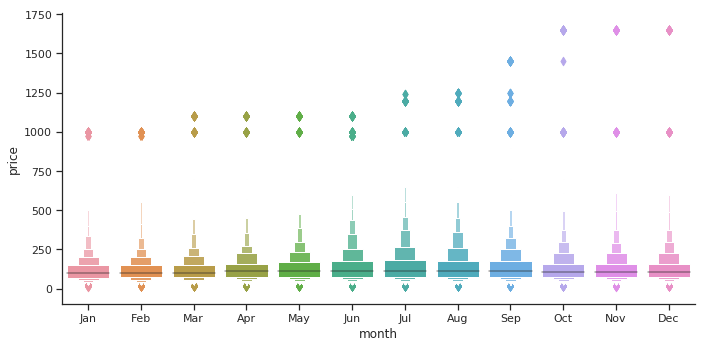

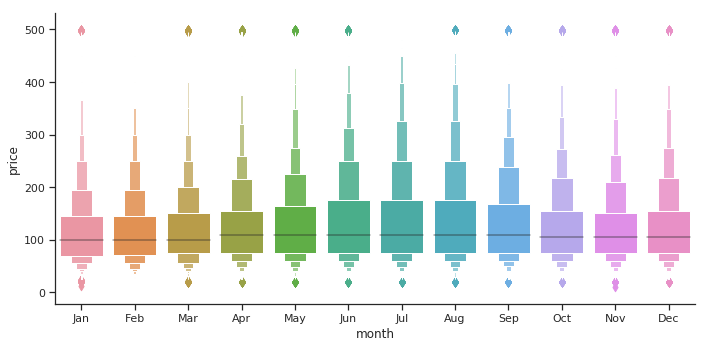

In [154]:
# Display
sns.set(style="ticks",color_codes=True)
sns.catplot(x="month", y="price", kind='boxen', data=calendar_price[calendar['available']==1],height=5,aspect=2);
price_without_outlier = calendar[calendar_price['price'] < 500];
sns.catplot(x="month", y="price", kind='boxen', data=price_without_outlier[price_without_outlier['available']==1],height=5,aspect=2);

If we look at the price per month we see larger distributions around summer holidays and some outliers
during winter with price jumps around the year revealing maybe different characteristics / standings

There are the same number of unique listings across the months


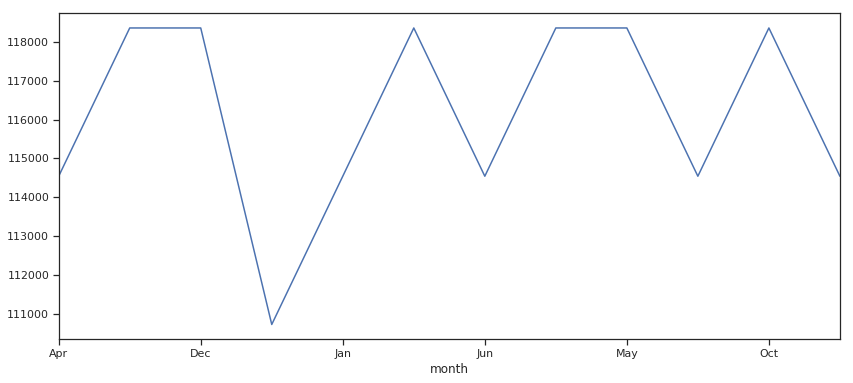

In [219]:
calendar_listings = calendar_price[['month','listing_id']].groupby(['month'])['listing_id'].count()
calendar_listings_unique = calendar_price[['month','listing_id']].groupby(['month'])['listing_id'].unique()
for element in calendar_listings_unique:
    same_listings =True 
    if len(element) != len(calendar_price['listing_id'].unique()):
        same_listings = False
        break
if same_listings:
    print('There are the same number of unique listings across the months')
calendar_listings.plot(figsize=(14,6));
#calendar_listings.head(12)

Property listings varies by about 0.6% across the year with an all year low around the new year

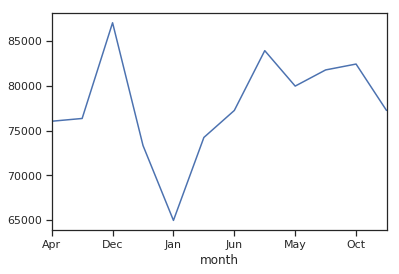

In [220]:
calendar_avail = calendar[calendar_price['available'] == 1];
calendar_avail = calendar_avail.groupby('month')['available'].count()
calendar_avail.plot();

## Listings

In [12]:
print(listings.shape)
check_data(listings)    
listings.head()

(3818, 92)

- id :  
	unique values: 3818
	null values: 0

- listing_url :  
	unique values: 3818
	null values: 0

- scrape_id :  
	unique values: 1
	null values: 0

- last_scraped :  
	unique values: 1
	null values: 0

- name :  
	unique values: 3792
	null values: 0

- summary :  
	unique values: 3479
	null values: 177

- space :  
	unique values: 3120
	null values: 569

- description :  
	unique values: 3742
	null values: 0

- experiences_offered :  
	unique values: 1
	null values: 0

- neighborhood_overview :  
	unique values: 2507
	null values: 1032

- notes :  
	unique values: 2000
	null values: 1606

- transit :  
	unique values: 2575
	null values: 934

- thumbnail_url :  
	unique values: 3499
	null values: 320

- medium_url :  
	unique values: 3499
	null values: 320

- picture_url :  
	unique values: 3818
	null values: 0

- xl_picture_url :  
	unique values: 3499
	null values: 320

- host_id :  
	unique values: 2751
	null values: 0

- host_url :  
	unique values: 2751
	null valu

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [13]:
# Removing uselss data for column in listings.columns.values:
for column in listings.columns.values:
    if len(listings[column].unique()) == 1:
        listings = listings.drop(column,axis=1)
        print("Removed ",column)

listings.shape
listings.describe()


Removed  scrape_id
Removed  last_scraped
Removed  experiences_offered
Removed  market
Removed  country_code
Removed  country
Removed  has_availability
Removed  calendar_last_scraped
Removed  requires_license
Removed  license
Removed  jurisdiction_names


(3818, 81)

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000
mean,5.550111e+06,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,2.962660e+06,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348
min,3.335000e+03,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,3.258256e+06,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000
50%,6.118244e+06,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,8.035127e+06,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000
max,1.034016e+07,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


In [14]:
# Converting bool and removing dollars
boolean_str =['host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable',
              'require_guest_profile_picture','require_guest_phone_verification']
prices = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for column in boolean_str:
    listings[column] = convert_boolstr(listings[column])

for column in prices:
    listings[column] = remove_dollar(listings[column])


In [98]:
# Display
check_data(listings)  
listings.shape


- id :  
	unique values: 3818
	null values: 0

- listing_url :  
	unique values: 3818
	null values: 0

- name :  
	unique values: 3792
	null values: 0

- summary :  
	unique values: 3479
	null values: 177

- space :  
	unique values: 3120
	null values: 569

- description :  
	unique values: 3742
	null values: 0

- neighborhood_overview :  
	unique values: 2507
	null values: 1032

- notes :  
	unique values: 2000
	null values: 1606

- transit :  
	unique values: 2575
	null values: 934

- thumbnail_url :  
	unique values: 3499
	null values: 320

- medium_url :  
	unique values: 3499
	null values: 320

- picture_url :  
	unique values: 3818
	null values: 0

- xl_picture_url :  
	unique values: 3499
	null values: 320

- host_id :  
	unique values: 2751
	null values: 0

- host_url :  
	unique values: 2751
	null values: 0

- host_name :  
	unique values: 1467
	null values: 2

- host_since :  
	unique values: 1381
	null values: 2

- host_location :  
	unique values: 121
	null values: 8

- ho

(3818, 81)

In [100]:
listings.head()

,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1.0,1.0,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,"Seattle, WA",47.636289,-122.371025,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,5.0,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1.0,1.0,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,"Seattle, WA",47.639123,-122.365666,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,https://a2.muscache.com/ac/pictures/b4324e0f-a

## Reviews

In [102]:
print(reviews.shape)
reviews.head()

(84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015,34959538,Ming,Kelly was a great host and very accommodating ...


In [101]:
check_data(reviews)    
reviews['date'] = [x[:-3] for x in reviews['date']]


- listing_id :  
	unique values: 3191
	null values: 0

- id :  
	unique values: 84849
	null values: 0

- date :  
	unique values: 79
	null values: 0

- reviewer_id :  
	unique values: 75730
	null values: 0

- reviewer_name :  
	unique values: 14380
	null values: 0

- comments :  
	unique values: 84137
	null values: 18


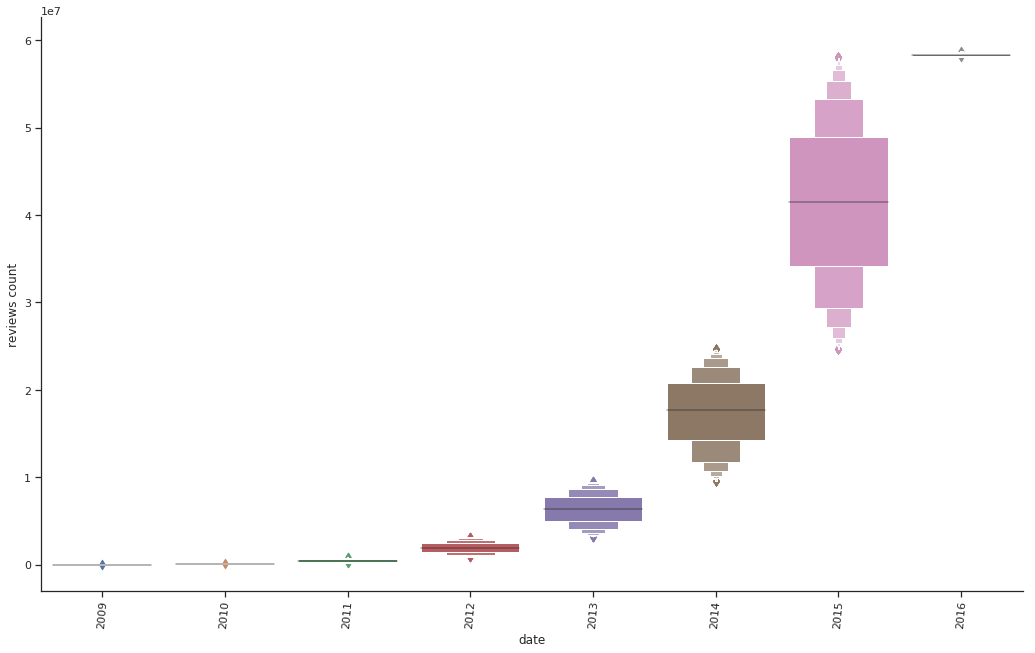

In [105]:
reviews_desc = reviews[['listing_id','id','date']]
reviews_evolution = reviews_desc.groupby(['date']).count()
reviews_evolution.head()
reviews_evolution.shape
sns.set(style="ticks", color_codes=True);
cp = sns.catplot(x="date", y="id", kind='boxen', data=reviews_desc.sort_values('date'),height=5,aspect=2);
cp.set_xticklabels(rotation=85);
cp.fig.set_size_inches(15,10);
cp.ax.set_ylabel('reviews count');

#### The steep increase of reviews count per month clearly show the increase of popularity for AirBNB

In [18]:
listings['id'].describe()
calendar['listing_id'].describe()
#Identical listings

count    3.818000e+03
mean     5.550111e+06
std      2.962660e+06
min      3.335000e+03
25%      3.258256e+06
50%      6.118244e+06
75%      8.035127e+06
max      1.034016e+07
Name: id, dtype: float64

count    1.393570e+06
mean     5.550111e+06
std      2.962274e+06
min      3.335000e+03
25%      3.258213e+06
50%      6.118244e+06
75%      8.035212e+06
max      1.034016e+07
Name: listing_id, dtype: float64

In [97]:
listings['price'] = listings['price'].astype(float)
price_ranges = pd.qcut(listings['price'],4)
price_ranges.cat.categories

def setcolor_by_price(price):
    color = 'black'
    if price in price_ranges.cat.categories[0]:
        color = 'lightred'
    elif price in price_ranges.cat.categories[1]:
        color = 'red'
    elif price in price_ranges.cat.categories[2]:
        color = 'darkred'
    else:
        color = 'black'
    return color


IntervalIndex([(19.999, 75.0], (75.0, 100.0], (100.0, 150.0], (150.0, 1000.0]],
              closed='right',
              dtype='interval[float64]')

In [108]:
%%capture
data = listings[['longitude','latitude']];
data['color'] = [setcolor_by_price(p) for p in listings['price']];

In [95]:
%%capture
init = [data['latitude'].mean(),data['longitude'].mean()]
map_osm = fo.Map(location=init,zoom_start=11)
data.apply(lambda row:fo.CircleMarker(
                        location=[row["latitude"], row["longitude"]],
                        color=row["color"],fill=True,
                        fill_opacity=0.5,
                        opacity=0.4,
                        weight=2,
                        radius=3,
                         ).add_to(map_osm),
                        axis=1)

In [96]:
map_osm

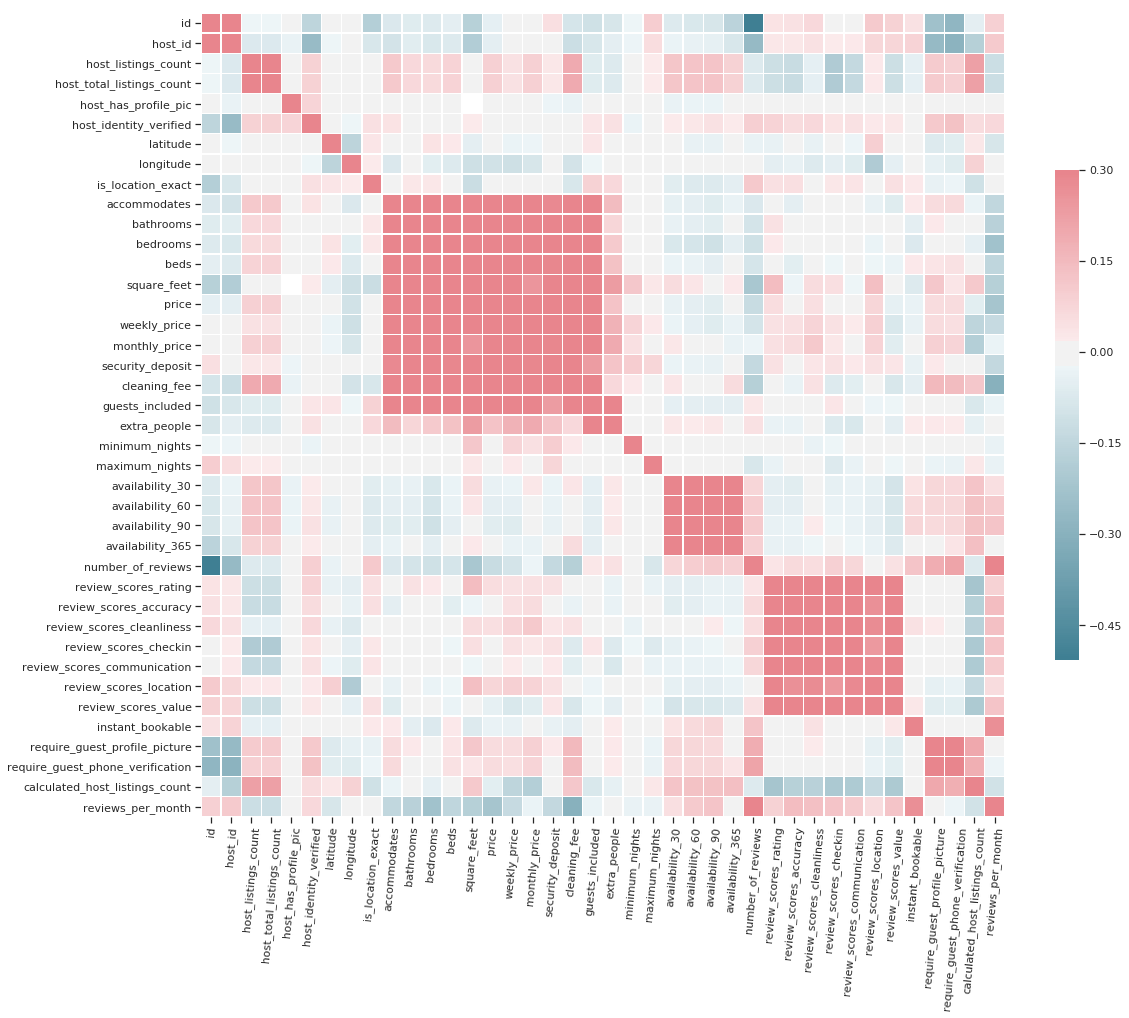

In [107]:
# Compute the correlation matrix
numeric_fields = []
for column in listings.columns.values:
    if listings[column].dtype in ['int64','float64']:
        numeric_fields.append(column)

listings_numerical = listings[numeric_fields]
corr = listings_numerical.corr()

#%%
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5});
hm.set_xticklabels(labels=hm.get_xticklabels(),rotation=85);

As expected we see a high correlation between property characteristics and price + additionnal fees

def get_day(date):
    new_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return new_date.strftime("%b")

def get_year(date):
    new_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return new_date.year